## HEART SOUND ANALYSIS AND CLASSIFICATION 

### 1. Introducción

Antes de empezar con el análisis y la clasificación de los distintos sonidos, se procede a explicar en qué consiste el análisis y cómo son los datos de los que se dispone.

Los sonidos del corazón son muy característicos del propio individuo y son generados por los latidos del corazón y el flujo de sangre a través de él. En los adultos sanos, hay dos sonidos cardíacos normales, comúnmente descritos como __lub__ y __dub__ (o dup). Estas onomatopeyas habituales constituyen los dos sonidos característicos de un corazón sano siendo __lub__ el primer sonido cardíaco __(S1)__ y __dub__ (o dup) el segundo sonido cardíaco __(S2)__. Ambos ocurren en secuencia con cada latido del corazón y se producen por el cierre de válvulas auriculoventriculares y semilunares, respectivamente.


### 2. Contenido 

Los datos de los que se dispone se dividen en dos conjuntos de datos diferentes, el __set A__ y el __set B__. Además de los audios correspondientes, se dispone también de varios ficheros __.csv__ que nos proporcionan diferente información:

    - set_a.csv : contiene etiquetas y metadatos de latidos del corazón recopilados del público en general a través de una aplicación para iPhone.

    - set_a_timing.csv : contiene información de tiempo estándar para las grabaciones "normales" del conjunto A.

    - set_b.csv : contiene etiquetas y metadatos de latidos cardíacos recopilados en un ensayo clínico en hospitales con un estetoscopio digital.

    - archivos de audio : diferentes longitudes de audios que van desde 1 a 30 segundos. En algunos casos, los archivos se han recortado para reducir el ruido excesivo de los mismos y proporcionar así el frangmentos saliente del sonido. 


### 3.1 Exploración de los datos

En primer lugar, se procede a analizar los datos del directorio __archive__ tanto en contenido como en organización:

In [1]:
import warnings   
import IPython.display as ipd
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing # gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Carga de los datos correspondientes al conjunto A
set_a=pd.read_csv('./archive/set_a.csv')
print(set_a.label.unique())
set_a.head()


['artifact' 'extrahls' 'murmur' 'normal' nan]


dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [3]:
# Carga de los datos correspondientes al conjunto B
set_b=pd.read_csv('./archive/set_b.csv')
print(set_b.label.unique())
set_b.head()

['extrastole' 'murmur' 'normal' nan]


dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

Con el fin de poder tener todos los datos en un mismo conjunto de datos, se unen ambos datasets para así trabajar de una forma más cómoda y rápida. De esta manera, se dispondrá de todos los labels en un mismo dataframe pues, como se puede ver en los resultados anteriores, para los audios grabados con la aplicación de iPhone __(setA)__ existen *_5 clases diferentes_* mientras que, para el caso del __setB__ se dispone de *_4 clases distintas_*.

In [4]:
datasets = [set_a, set_b]
train_dataset=pd.concat(datasets)
print("Número de classes: {}".format(len(train_dataset.label.unique())))
print("Clases: {}".format(train_dataset.label.unique()))
print("Número de observaciones/audios: {}".format(len(train_dataset)))
train_dataset.head()

Número de classes: 6
Clases: ['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']
Número de observaciones/audios: 832


dataset                             fname     label sublabel
0       a  set_a/artifact__201012172012.wav  artifact      NaN
1       a  set_a/artifact__201105040918.wav  artifact      NaN
2       a  set_a/artifact__201105041959.wav  artifact      NaN
3       a  set_a/artifact__201105051017.wav  artifact      NaN
4       a  set_a/artifact__201105060108.wav  artifact      NaN

Como se puede ver en el ouput de la celda anterior, el nuevo dataset creado tiene la misma forma que los sets A y B con la única diferencia de que ahora se dispone de todos los datos en un mismo dataframe. A partir de los datos de los que se dispone, interesa saber cómo estan distribuidos los mismos, es decir, cuántos audios hay para cada categoría de sonidos __(extrahls,artifact,extrastole,murmur,normal)__.

Es importante recalcar que la clase nan corresponde a los audios que no han sido etiquetados o clasificados durante el proceso de obtención de datos.

Además, es interesante ver cómo estan distribuidos los datos, es decir, de cuántos audios se dispone para cada label para así tener una idea de la cantidad de los datos que se van a usar.

Min nº de muestras por categoría =  19
Max nº de muestras por categoría =  351


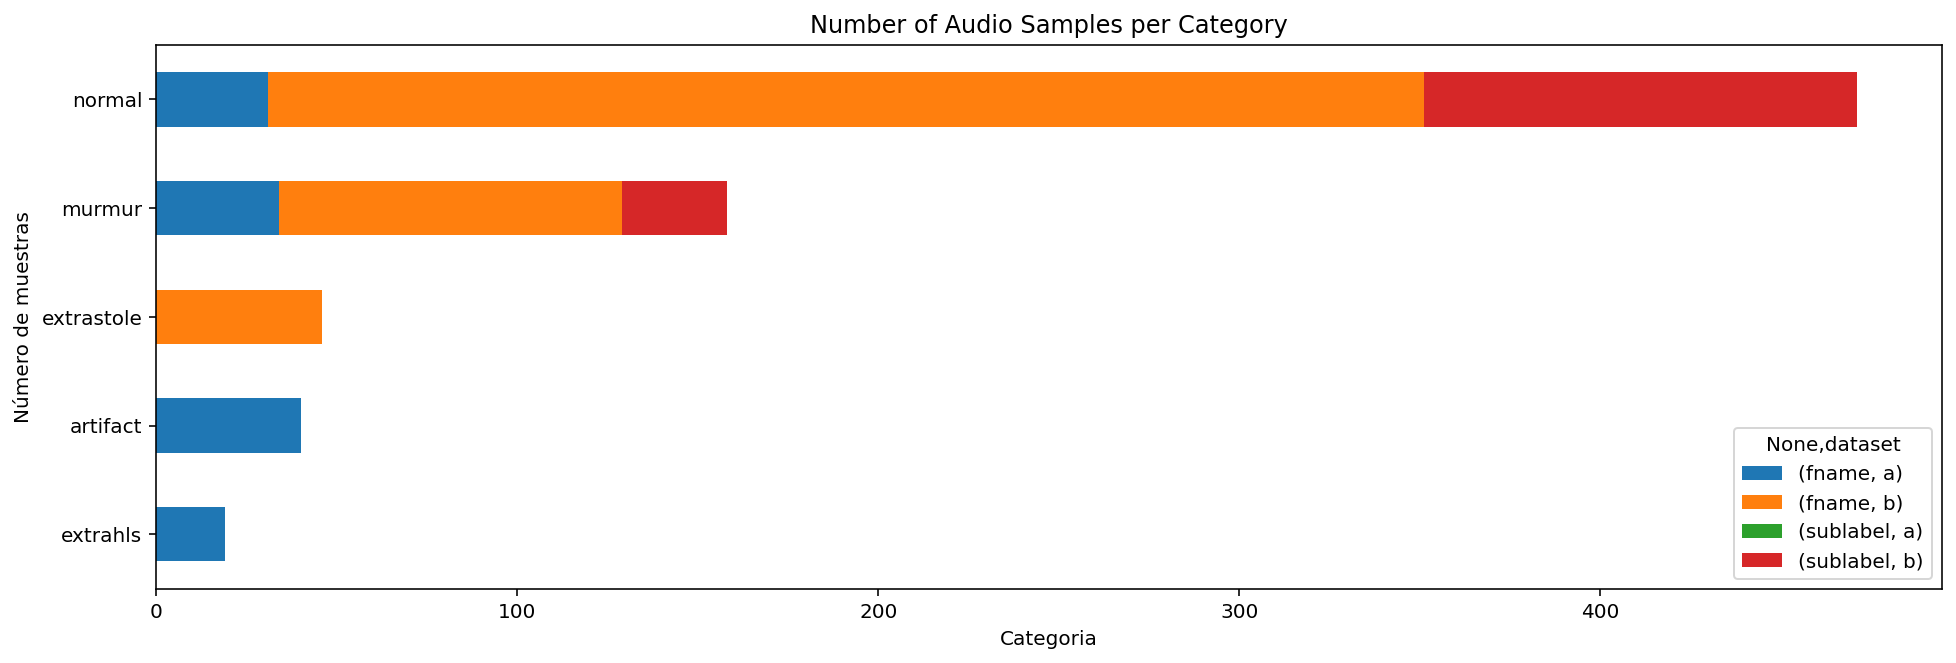

In [5]:
category_group = train_dataset.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index).plot(kind='barh', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Categoria")
plot.set_ylabel("Número de muestras")

print('Min nº de muestras por categoría = ', min(train_dataset.label.value_counts()))
print('Max nº de muestras por categoría = ', max(train_dataset.label.value_counts()))

A partir del gráfico anterior, se puede concluir que de la categoría __extrahls__ se tienen pocos audios, en concreto un total de __19 audios__ pues esta categoria se corresponde a la catgoría con minímo número de muestras. Por el contrario, para el caso de los audios de la categoría __normal__ se dispone de __351 muestras__ conformado así la categoría con un mayor número de muestras.

A continuación, se dispone a analizar cada una de las categorías de sonidos para identificar cómo se escuchan y, además, se muestran diferentes gráficos en diferentes dominios que proporcionarán diferente información acerca de los distintos audios. Las distintas categorías a analizar son las siguientes: 

    - Normal
    - Murmur
    - Extrasístole
    - Artefacto
    - Sonido extra del corazón

Los gráficos que se mostrarán para cada categoría se corresponden con la forma de onda, el espectograma y el MFCC respectivamente para cada uno de los sonidos usados de ejemplo. A continuación, se explica brevemente qué información nos proporciona cada uno de ellos:

   - _Waveform_ : las __ondas__ son señales repetidas que oscilan y varían en amplitud dependiendo de su complejidad. En el mundo real, las ondas son continuas y mecánicas, lo cual es bastante diferente de las ondas que se ven en el ordenador que son discretas y digitales. Es por ello por lo que es necesario el sample rate pues nos permitirá modelar la onda continua a partir de una onda discreta y digita. Si por ejemplo se tiene una frecuencia de muestreo de 100, esto significa que por cada segundo de audia, el ordenador colocará 100 puntos a lo largo de la señal en un intento por trazar mejor la curva continua. Una vez que todos los puntos están en su lugar, una curva suave los une a todos para que los humanos puedan visualizar el sonido. Dado que el audio grabado está en términos de __amplitud__ y __tiempo__, podemos decir intuitivamente que la forma de onda opera en el __dominio del tiempo__.
   
   

   
   - _Spectogram_ : los espectogramas se podrían entender como imágenes de audio. Estos representan el espectro de frecuencia de un adio grabado a lo largo del tiempo. Esto significa que a medida que el _color_ de la imagen se vuelve _más brillante_ , el sonido se __concentra fuertemente__ alrededor de esas frecuencias específicas, y a medida que se observan _colores más oscuros_ , el sonido se parece y se acerca más a lo que se conoce como __sonido vacío__ o __muerto__. De esta manera, se puede comprender bien la forma y estructura del audio sin tener que escucharlo. Para obtener los espectogramas, en resumen, se aplica lo que se conoce como __Short Time Fourier Transformation (STFT)__ dando lugar a una linea que representa la __magnitud__ frente a la __frecuencia__. posteriormente, se convierte el resultado a __decibelios__ y se obtiene el __output__. 
   
   
   
   
   - _MFCC_ : antes de explicar en qué consisten es necesario entender primero qué es la _escala MEL_ y por qué es útil. La _escala MEL_ es una transformación logarítmica de la frecuencia de una señal. La idea central de esta transformación es que los sonidos a la misma distancia en la _escala MEL_ se perciben como a la misma distancia que los humanos. Es decir, la mayoría de seres humanos pueden distinguir fácilmente entre un sonido de 100Hz y un sonido de 200Hz. Sin embargo, por la misma razón, deberíamos asumir que podemos distinguir la diferencia entre 1000 y 1100 Hz. Pero esto no es verdad. Es mucho más dificil para los humanos distinguir entre frecuencias áltas y más fácil distinguir entre frecuencias bajas. Entonces, aunque la distancia entre los dos conjuntos de sonidos es la misma, nuestra percepción de la distancia no lo es. Esto es lo que hace que __Mel Scale__ sea fundamental en las aplicaciones de Machine Learning para audio, ya que imita nuestra propia __percepción del sonido__.
   
   <img src="Mel.png">
   
En conclusión, se ha visto que el _Spectogram_ permite visualizar un audio y la presión con la que las ondas se crean. Por otro lado, el MFCC representa la percepción humana bastante bien.

In [6]:
#Definimos las funciones que nos van a permitir realizar el espectograma y el MFCC respectivamente
def plot(audio: str = 'archive/set_a/normal__201106111136.wav', plot_type: str = 'spectogram', audio_type: str = 'NORMAL'):
    y, sr = librosa.load(audio) 
    dur = librosa.get_duration(y)
    print('El sampling rate por defecto es: {}'.format(sr))
    print ('La duración del audio es: {}'.format(dur))
    print('El tamaño de y (con las amplitudes correspondientes de la onda en t) es: {}'.format(y.shape))
    plt.figure(figsize=(18,5))
        
    if plot_type == 'waveform':
        librosa.display.waveplot(y, sr=sr)
        plt.title('Waveform - {}'.format(audio_type))
    
    elif plot_type == 'spectogram':
        spect = np.abs(librosa.stft(y))
        img=librosa.display.specshow(librosa.amplitude_to_db(spect, ref=np.max),x_axis='time', y_axis='log')
        plt.title('Power spectrogram - {}'.format(audio_type))
        plt.plot()
    
    else:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time') #from the literature the first 13th are the most representative
        print('Las dimensiones del MFCC son {} lo que implica que hay {} muestras y {} coeficientes de MFCC'.format(mfccs.shape, mfccs.shape[0], mfccs.shape[1])) #That's 388 samples and 13 Mel-frequency cepstral coefficients
        plt.title('MFCCS - {}'.format(audio_type))
        plt.colorbar()
        plt.plot()

### 3.1.1 Categoría normal

En la _categoría normal_ se encuentran los sonidos normales de un corazón sano. Puede haber ruido en el último segundo de cada uno de ellos puesto que el dispositivo es alejado en ese mismo momento del cuerpo así como ruidos de fondo (desde tráfico hasta radios). Por otro lado, también pueden existir ruidos procedentes de la propia respiración del individuo o de rozar el micrófono con la ropa o la piel. Un sonido normal del corazón (con una frecuencia cardíaca de menos de 140 latidos por minuto) tiene un patrón __lub dub, lub dub__ claro con un tiempo de __lub__ a __dub__ menor que de __dub__ al próximo __lub__

In [7]:
audio_normal = 'archive/set_a/normal__201106111136.wav'
ipd.Audio(audio_normal)

El sampling rate por defecto es: 22050
La duración del audio es: 4.963809523809524
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (109452,)


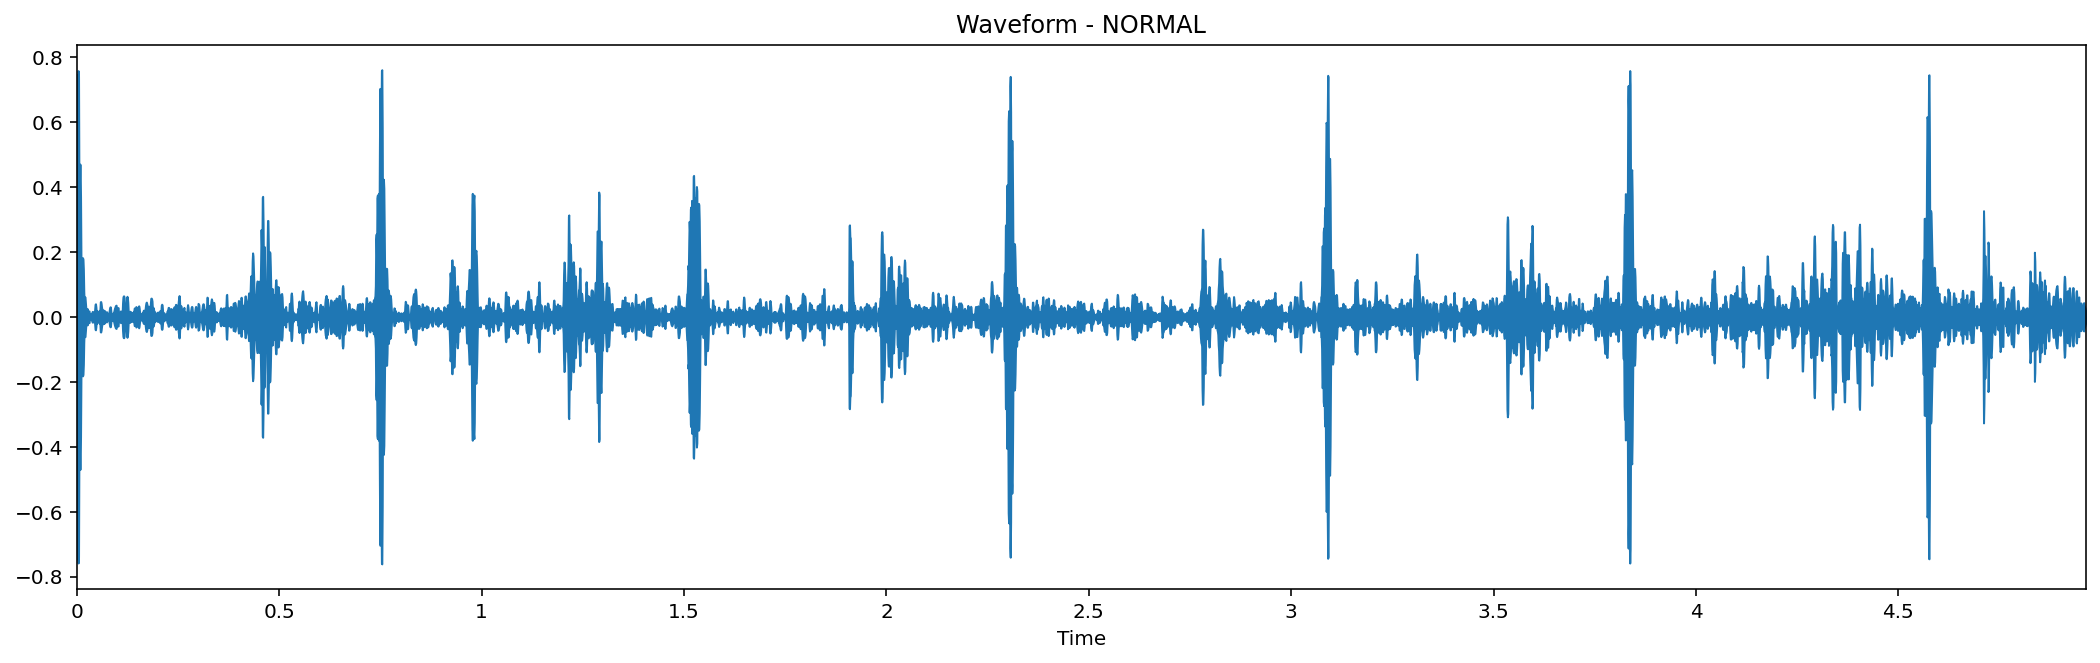

In [8]:
plot('archive/set_a/normal__201106111136.wav', 'waveform', 'NORMAL')

El sampling rate por defecto es: 22050
La duración del audio es: 4.963809523809524
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (109452,)


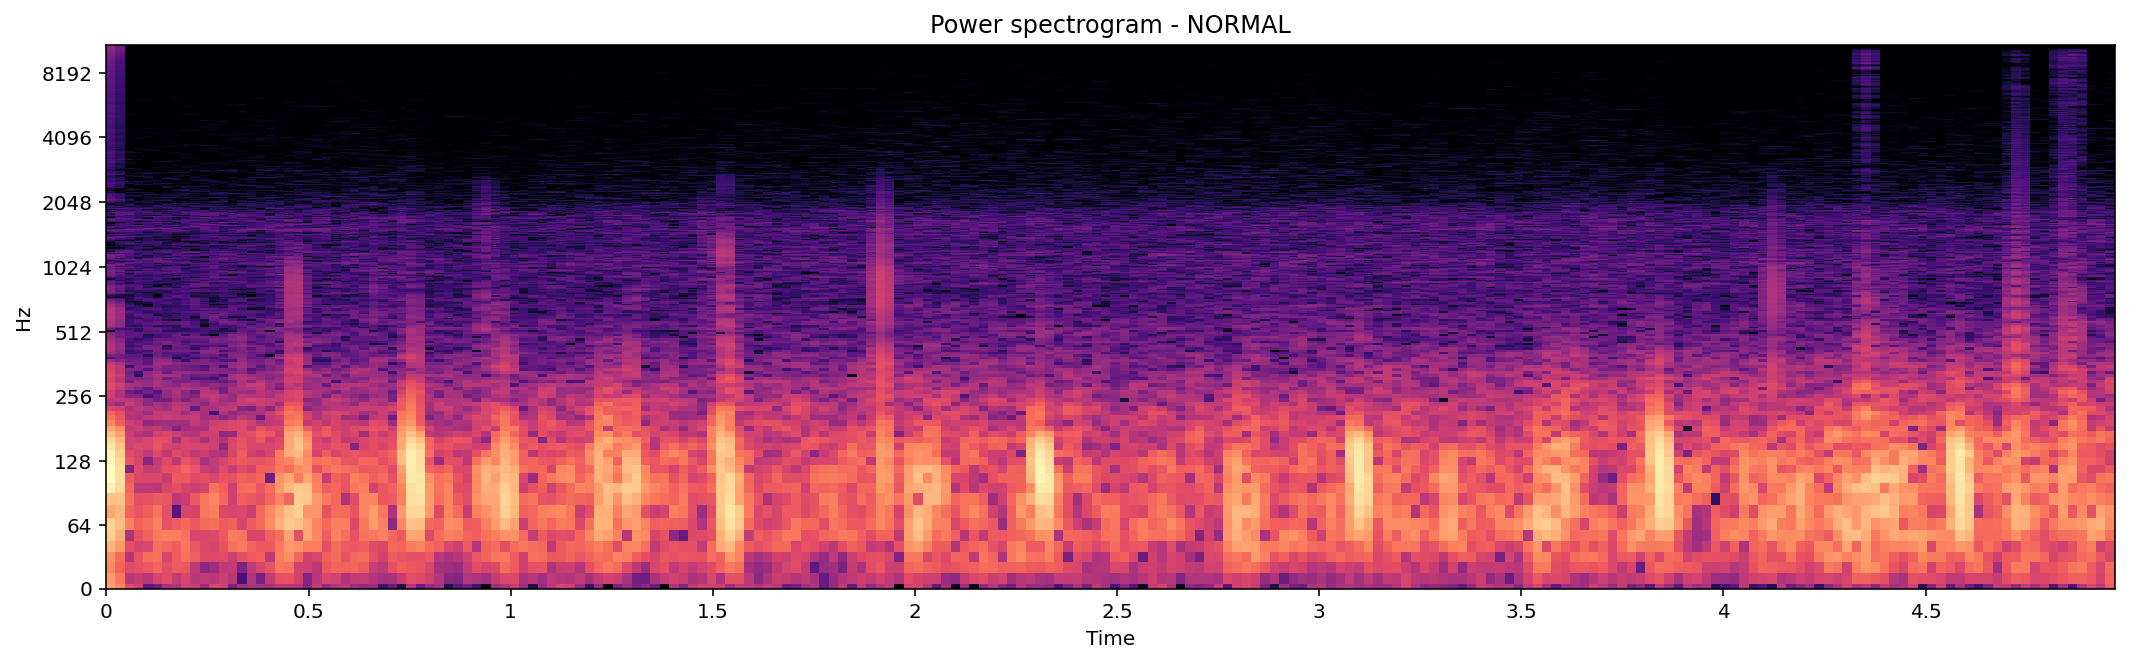

In [9]:
plot('archive/set_a/normal__201106111136.wav', 'spectogram', 'NORMAL')

El sampling rate por defecto es: 22050
La duración del audio es: 4.963809523809524
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (109452,)
Las dimensiones del MFCC son (13, 214) lo que implica que hay 13 muestras y 214 coeficientes de MFCC


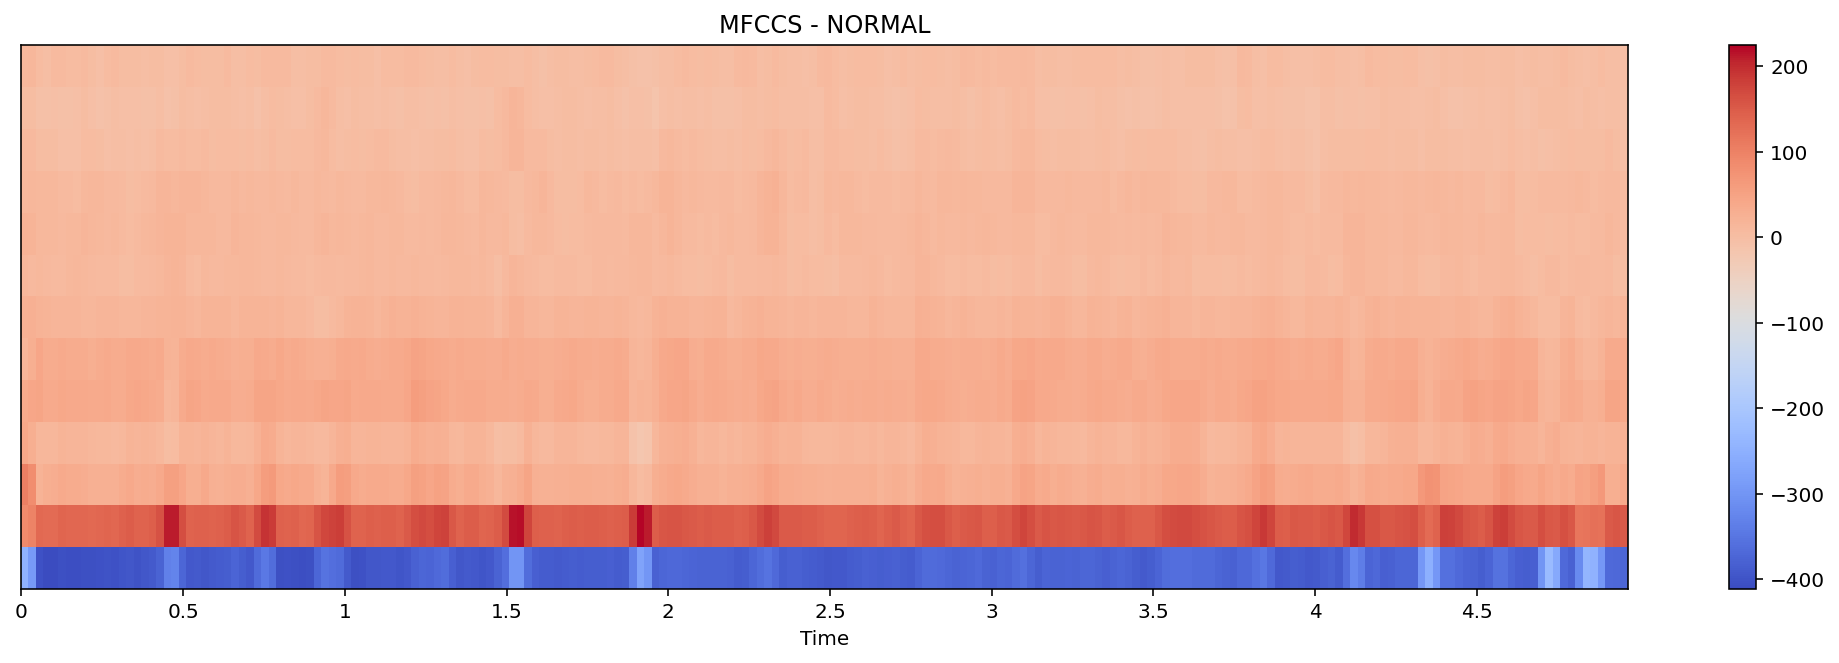

In [10]:
plot('archive/set_a/normal__201106111136.wav', 'MFCC', 'NORMAL')

### 3.1.2 Categoría Murmur

Los _soplos cardíacos_ suenan como si hubiera un __silbido__ o __fluido turbulento__ en una de dos ubicaciones temporales: 

   - Entre __lub__ y __dub__.
   - Entre __dub__ y __lub__.
   
Este tipo de sonidos pueden ser síntoma de muchos trastornos cardíacos, algunos muy graves. Sin embargo, el __lub__ __dub__ seguirá siendo parte del sonido aunque estará distorcionado por el _*flujo*_ anteriormente mencionado.

In [11]:
murmur = 'archive/set_a/murmur__201108222231.wav'
ipd.Audio(murmur)

El sampling rate por defecto es: 22050
La duración del audio es: 7.935555555555555
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (174979,)


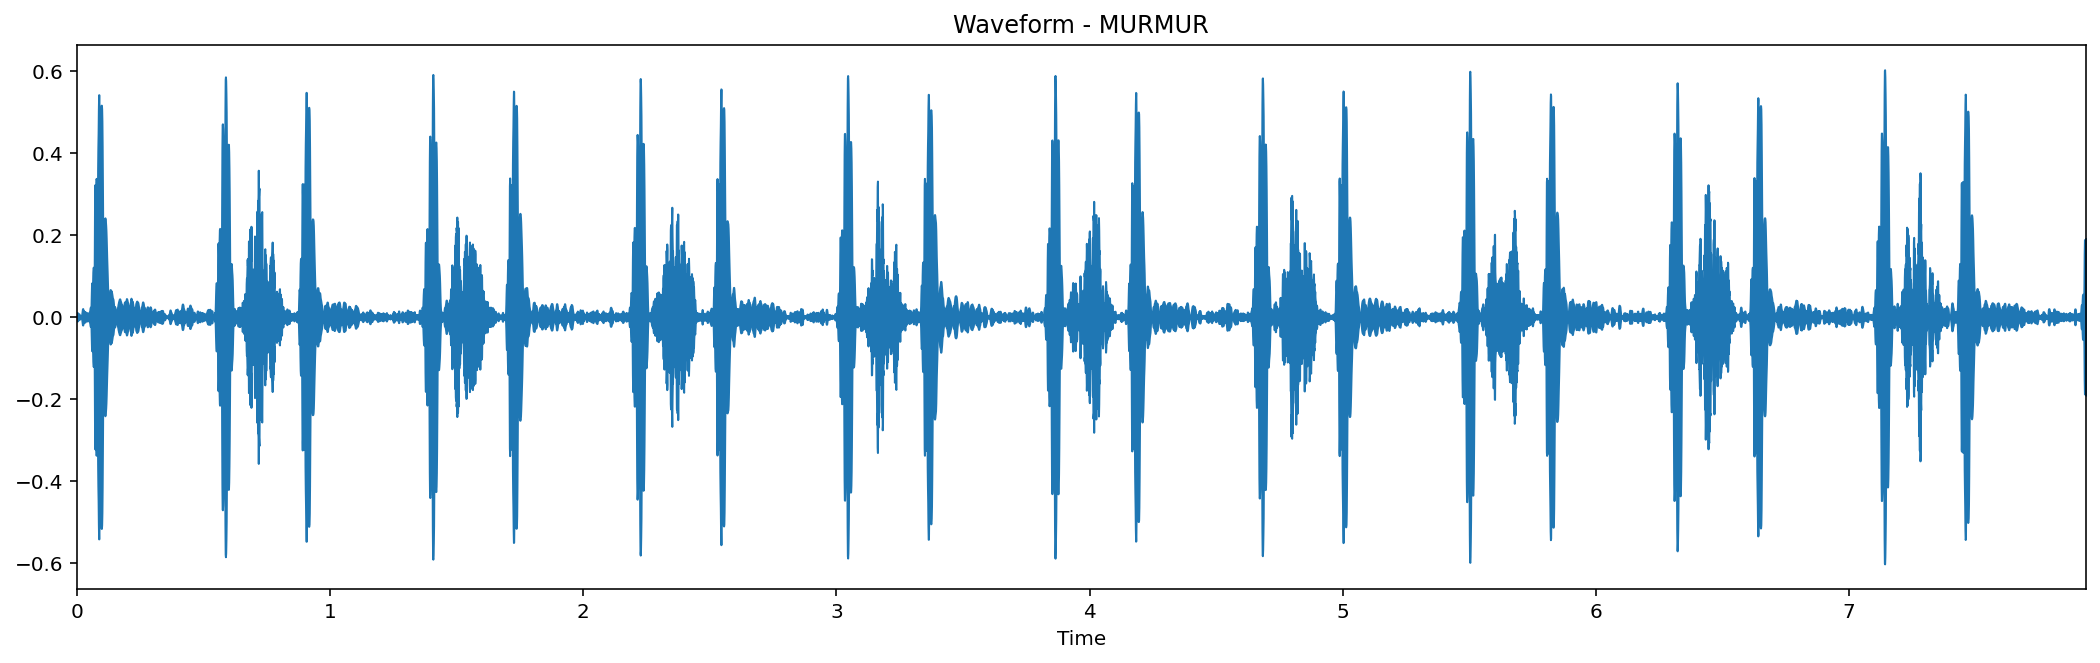

In [12]:
plot('archive/set_a/murmur__201108222231.wav', 'waveform', 'MURMUR')

El sampling rate por defecto es: 22050
La duración del audio es: 7.935555555555555
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (174979,)


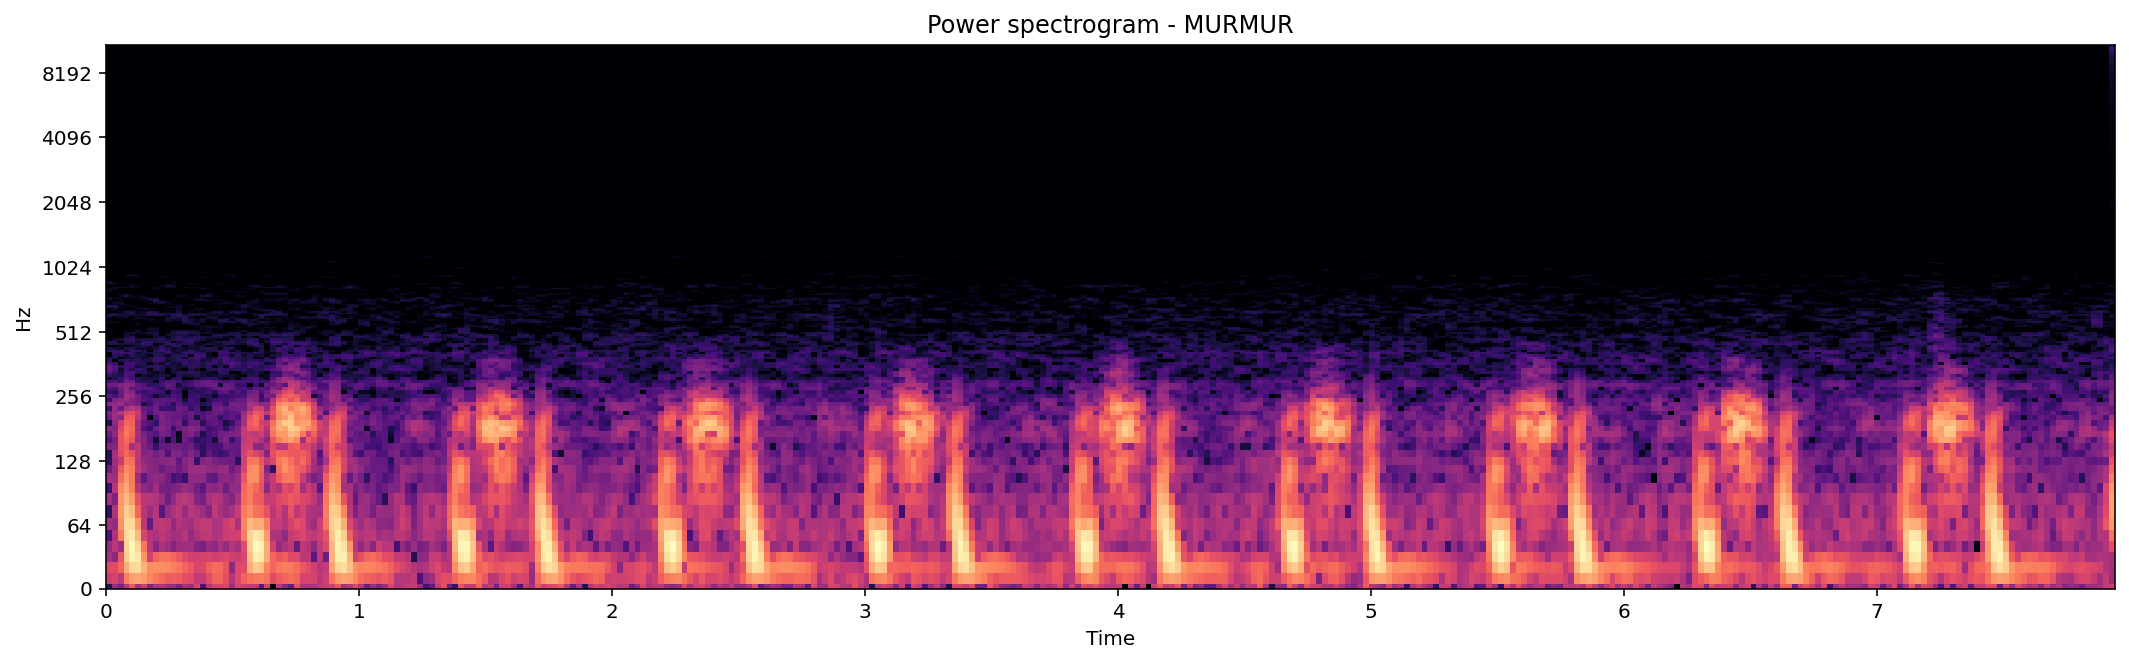

In [13]:
plot('archive/set_a/murmur__201108222231.wav', 'spectogram', 'MURMUR')

El sampling rate por defecto es: 22050
La duración del audio es: 7.935555555555555
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (174979,)
Las dimensiones del MFCC son (13, 342) lo que implica que hay 13 muestras y 342 coeficientes de MFCC


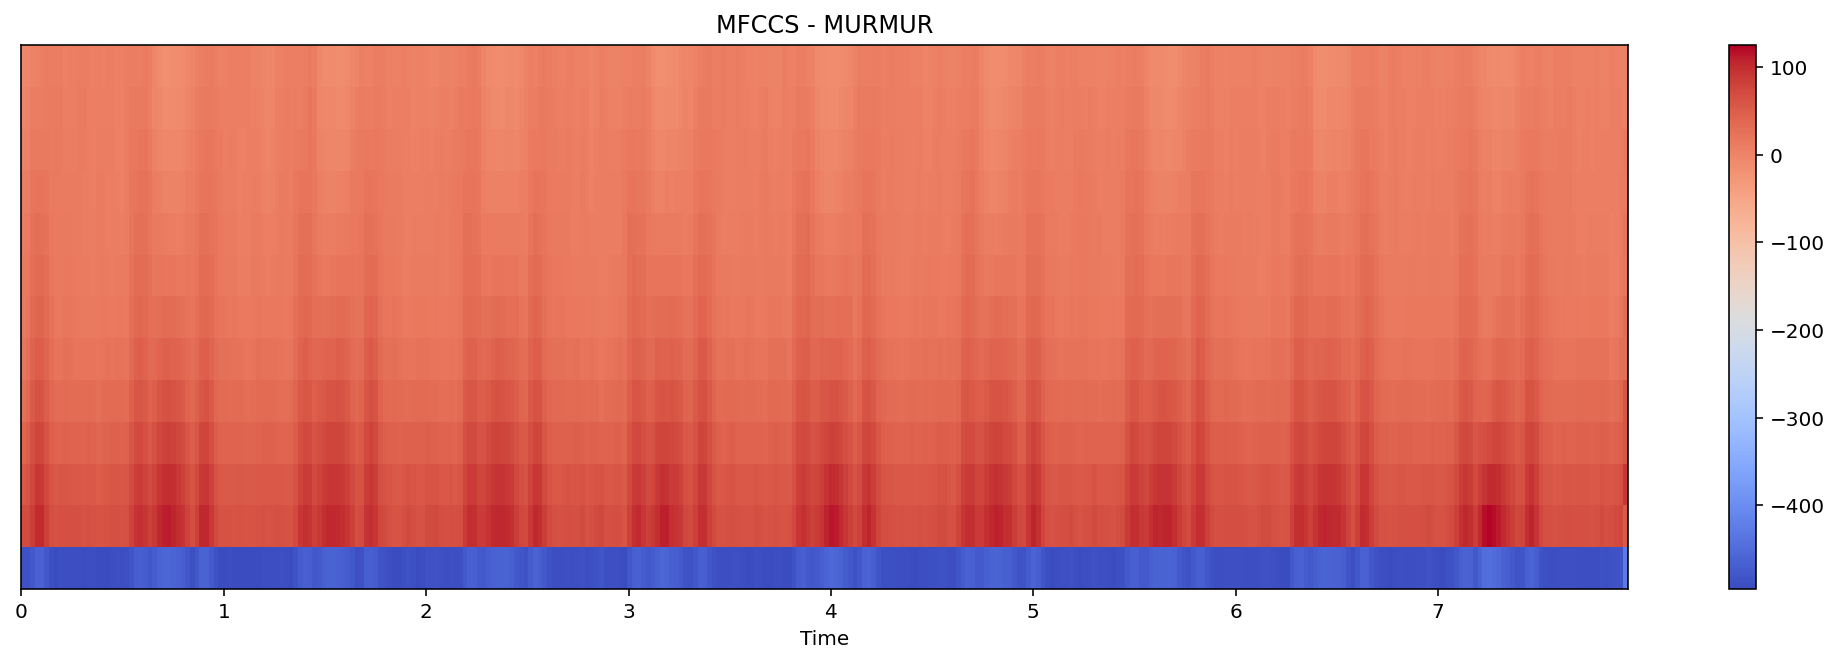

In [14]:
plot('archive/set_a/murmur__201108222231.wav', 'MFCC', 'MURMUR')

### 3.1.3 Categoría Extrasístole

Los _sonidos de extrasístole_ pueden aparecer ocasionalmente y pueden identificarse porque hay un ruido cardíaco que está fuera de ritmo y que implica latidos cardíacos adicionales o saltados. Por ejemplo, podría darse el caso de que el sonido siguiera el siguiente patrón: __lub-lub dub__ o un __lub dub-dub__. Esto no es lo mismo que un _ruido cardíaco adicional_ puesto que el evento no ocurre con regularidad. Una extrasístole puede no ser un signo de enfermedad. Es muy común en niños y suele ocurrir de manera normal en adultos. Sin embargo, si es verdad que en algunas situaciones las extrasístoles pueden ser causadas por enfermedades cardíacas. Si estas enfermedades se detectan antes, es probable que el tratamiento sea más eficaz.

In [15]:
extrasystole = 'archive/set_b/extrastole__210_1308162935880_C.wav'
ipd.Audio(extrasystole)

El sampling rate por defecto es: 22050
La duración del audio es: 9.685759637188209
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (213571,)


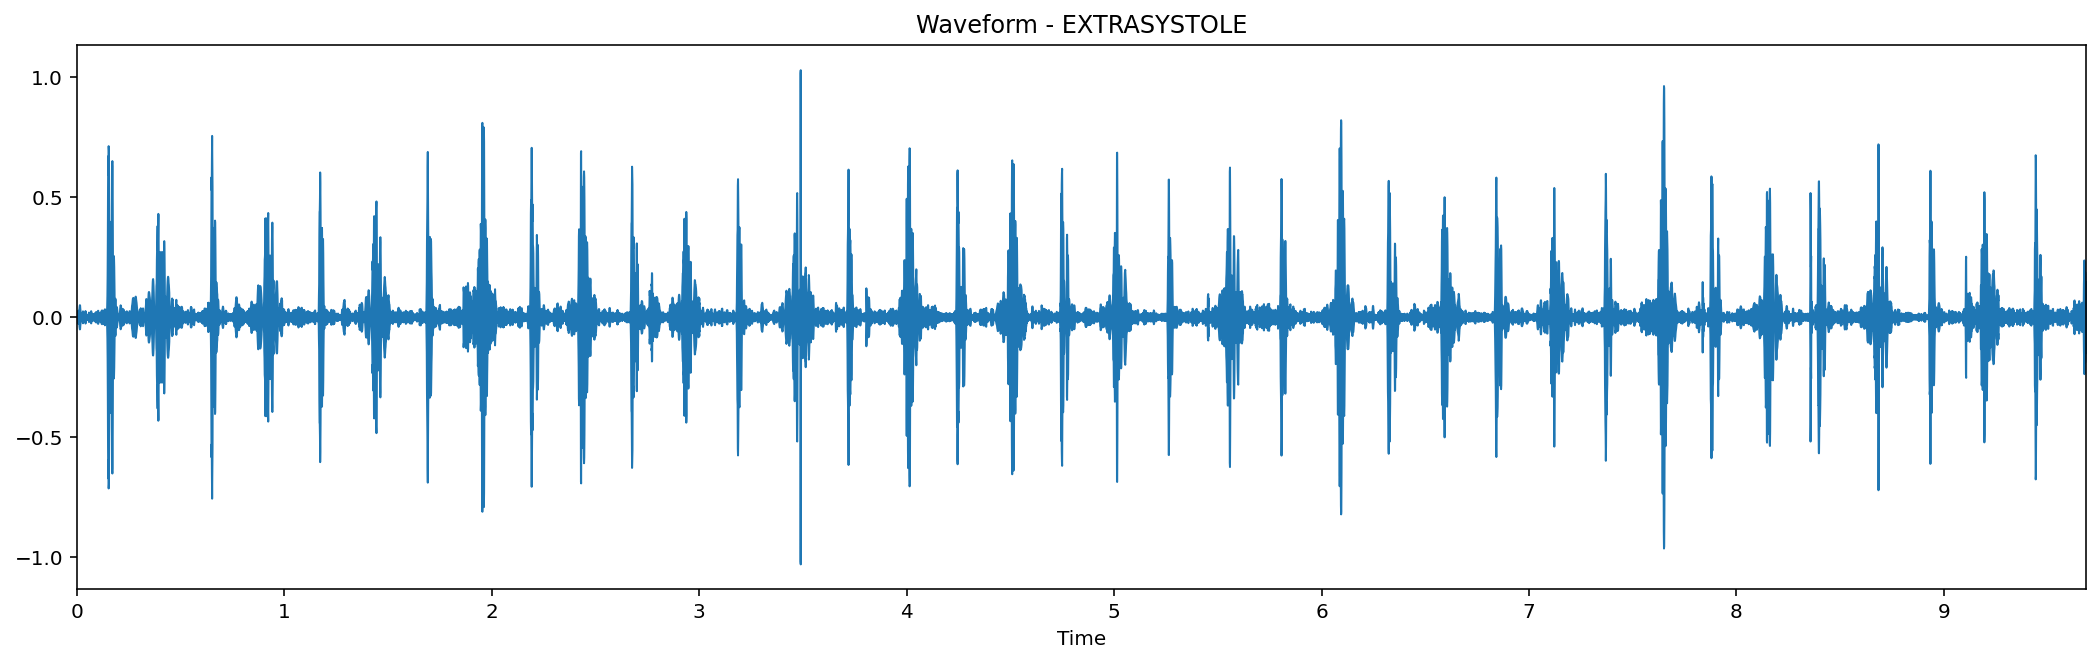

In [16]:
plot('archive/set_b/extrastole__210_1308162935880_C.wav', 'waveform', 'EXTRASYSTOLE')

El sampling rate por defecto es: 22050
La duración del audio es: 9.685759637188209
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (213571,)


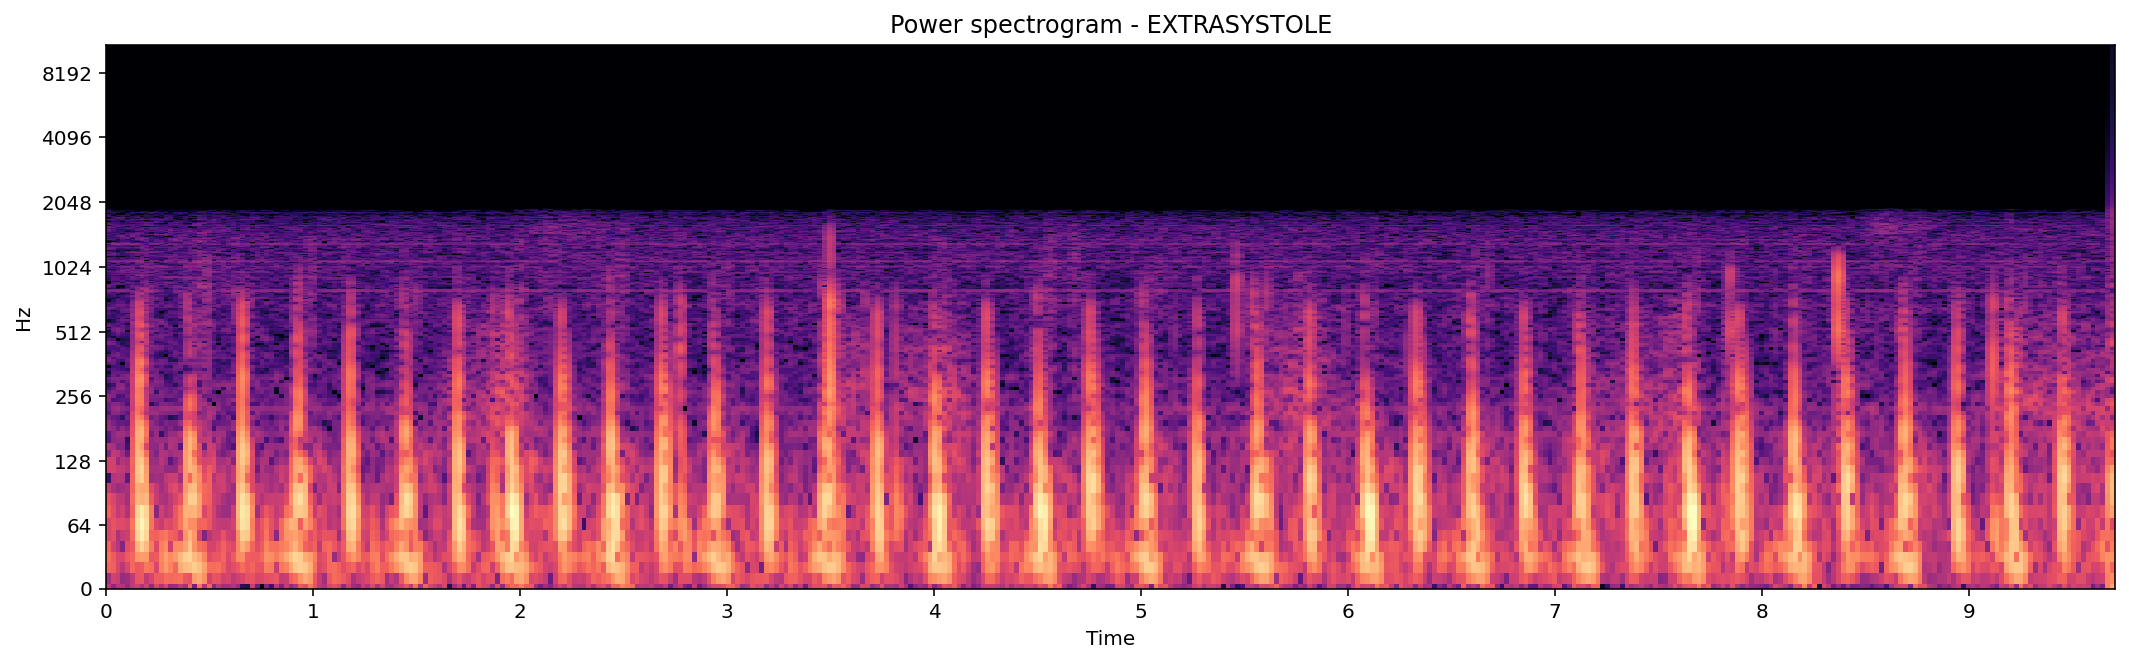

In [17]:
plot('archive/set_b/extrastole__210_1308162935880_C.wav', 'spectogram', 'EXTRASYSTOLE')

El sampling rate por defecto es: 22050
La duración del audio es: 9.685759637188209
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (213571,)
Las dimensiones del MFCC son (13, 418) lo que implica que hay 13 muestras y 418 coeficientes de MFCC


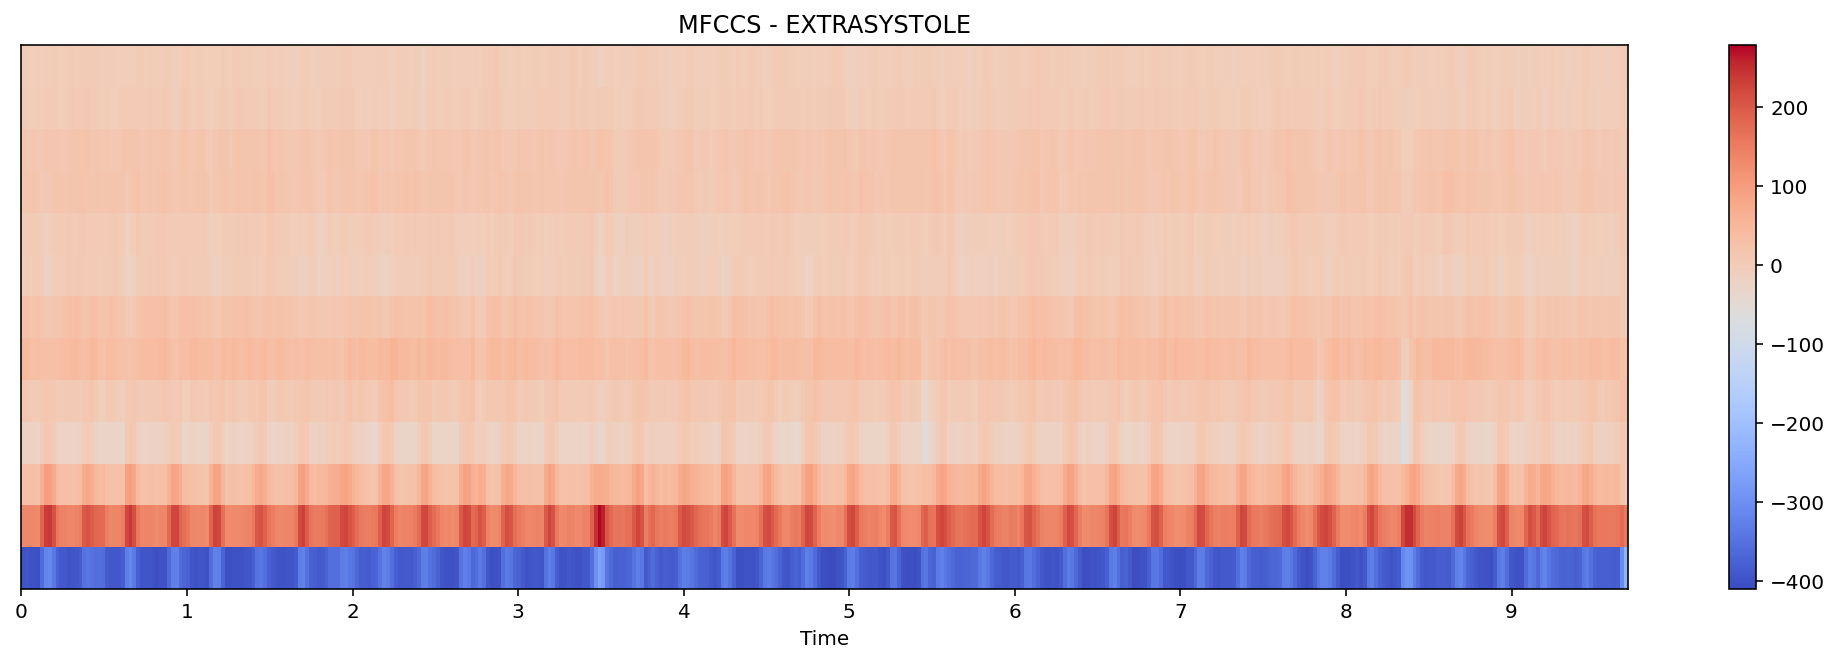

In [18]:
plot('archive/set_b/extrastole__210_1308162935880_C.wav', 'MFCC', 'EXTRASYSTOLE')

### 3.1.4 Categoría Artefacto

En la _*categoría Artefacto*_ hay una amplia gama de sonidos diferentes: chillidos, ecos de retroalimentación, habla, música y ruido, entre otros. Por lo general, no hay ruidos cardíacos discernibles y, por lo tanto, poca o ninguna periodicidad temporal en frecuencias por debajo de __195 Hz__. Esta categoría es la más diferente a las demás. Es importante poder distinguir esta categoría de las otras tres categorías.

In [19]:
artifact = 'archive/set_a/artifact__201106031558.wav'
ipd.Audio(artifact)

El sampling rate por defecto es: 22050
La duración del audio es: 9.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (198450,)


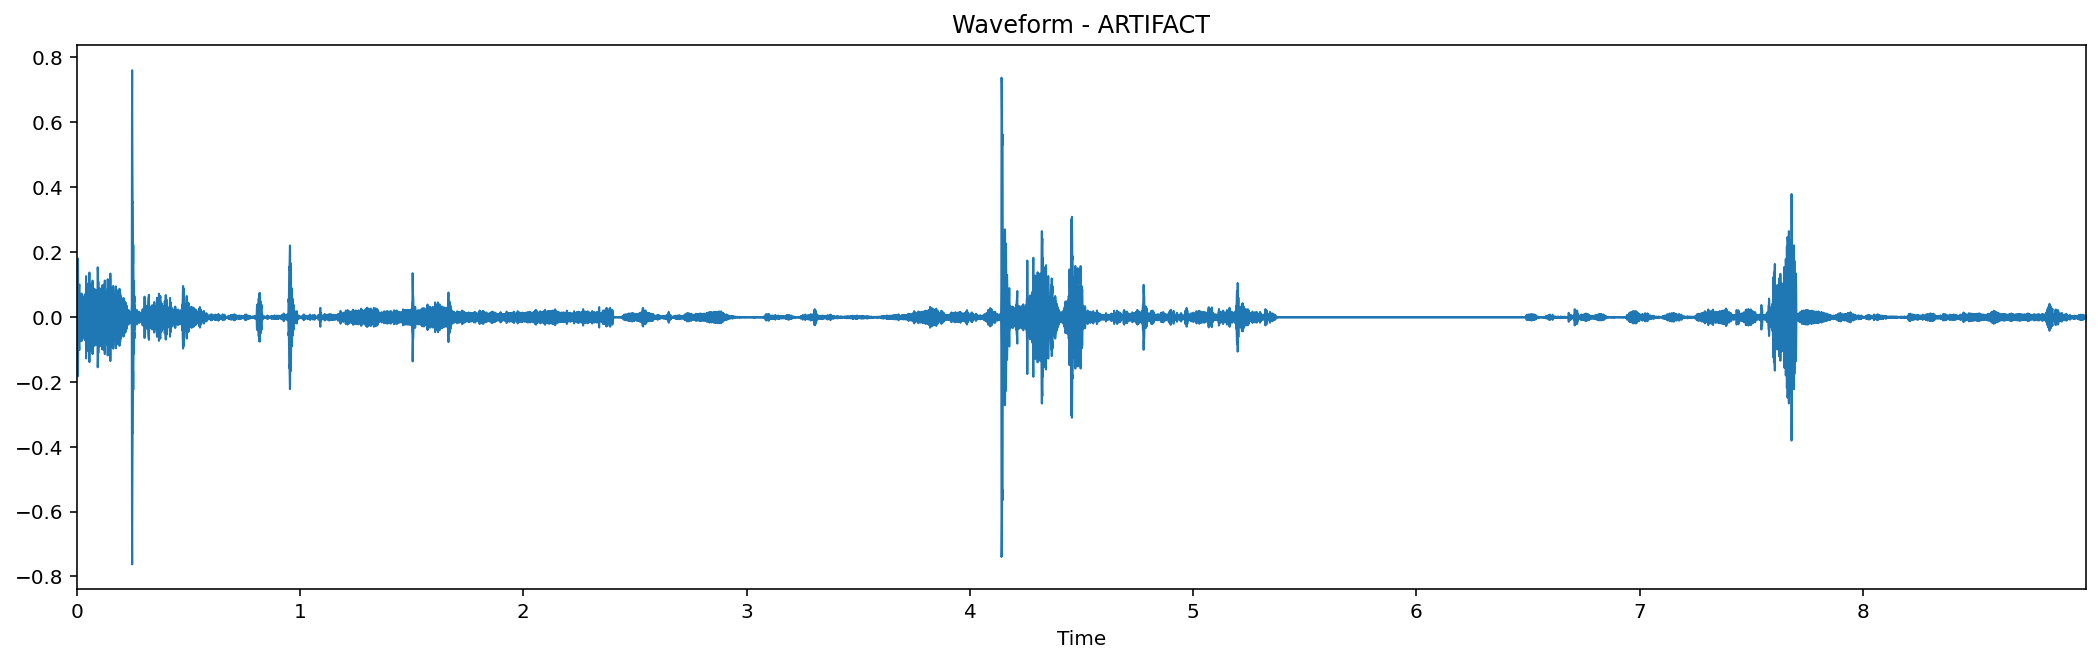

In [20]:
plot('archive/set_a/artifact__201106031558.wav', 'waveform', 'ARTIFACT')

El sampling rate por defecto es: 22050
La duración del audio es: 9.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (198450,)


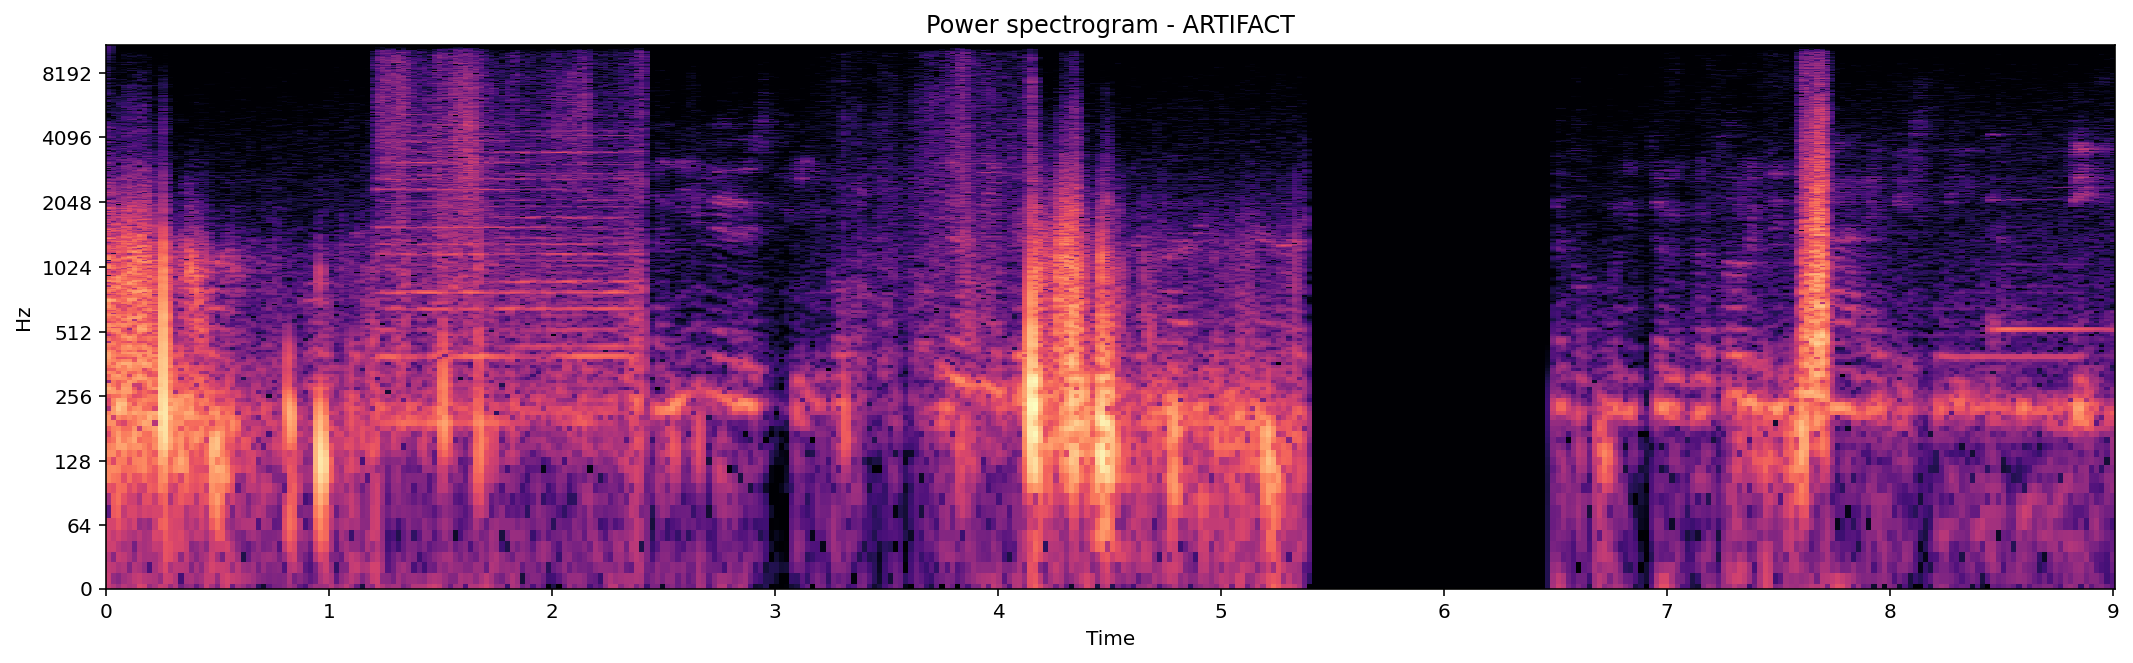

In [21]:
plot('archive/set_a/artifact__201106031558.wav', 'spectogram', 'ARTIFACT')

El sampling rate por defecto es: 22050
La duración del audio es: 9.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (198450,)
Las dimensiones del MFCC son (13, 388) lo que implica que hay 13 muestras y 388 coeficientes de MFCC


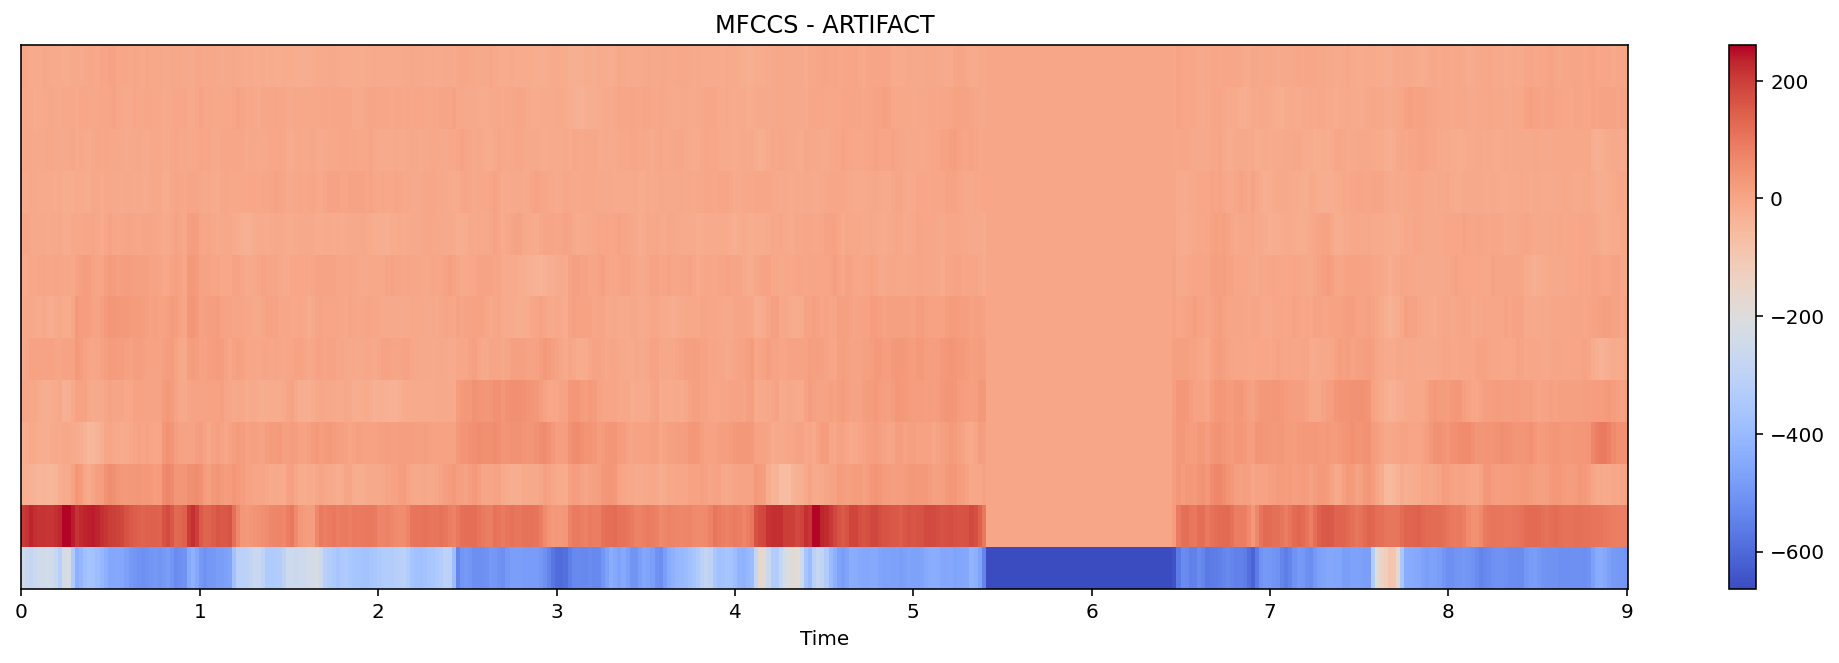

In [22]:
plot('archive/set_a/artifact__201106031558.wav', 'MFCC', 'ARTIFACT')

### 3.1.4 Sonido cardíaco adicional

Los _*ruidos cardíacos adicionales*_ se pueden identificar porque hay un sonido adicional, por ejemplo: un __lub-lub__ __dub__ o un __lub dub-dub__. Un ruido cardíaco adicional puede no ser un signo de enfermedad. Sin embargo, en algunas situaciones es un signo importante de enfermedad que, si se detecta a tiempo, podría ayudar al paciente. Es importante poder detectar el ruido cardíaco adicional, ya que no se puede detectar muy bien mediante una ecografía. A diferencia los sonidos de extrasístole estos ruidos cardíacos adicionales sí son constantes.

In [23]:
extrahls = 'archive/set_a/extrahls__201102241217.wav'
ipd.Audio(extrahls)

El sampling rate por defecto es: 22050
La duración del audio es: 9.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (198450,)


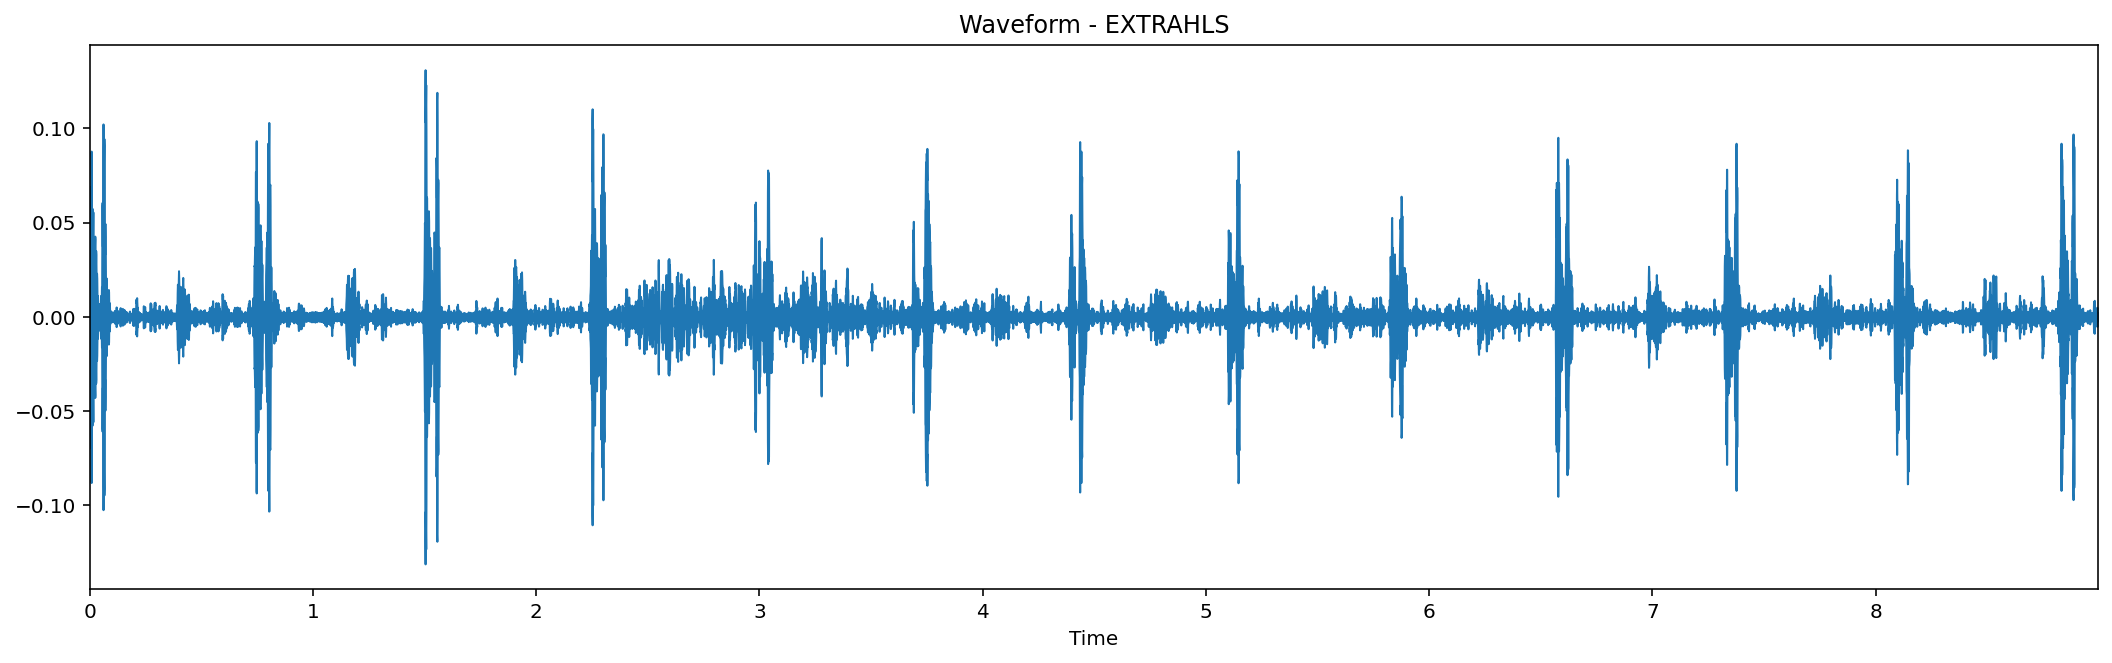

In [24]:
plot('archive/set_a/extrahls__201102241217.wav', 'waveform', 'EXTRAHLS')

El sampling rate por defecto es: 22050
La duración del audio es: 9.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (198450,)


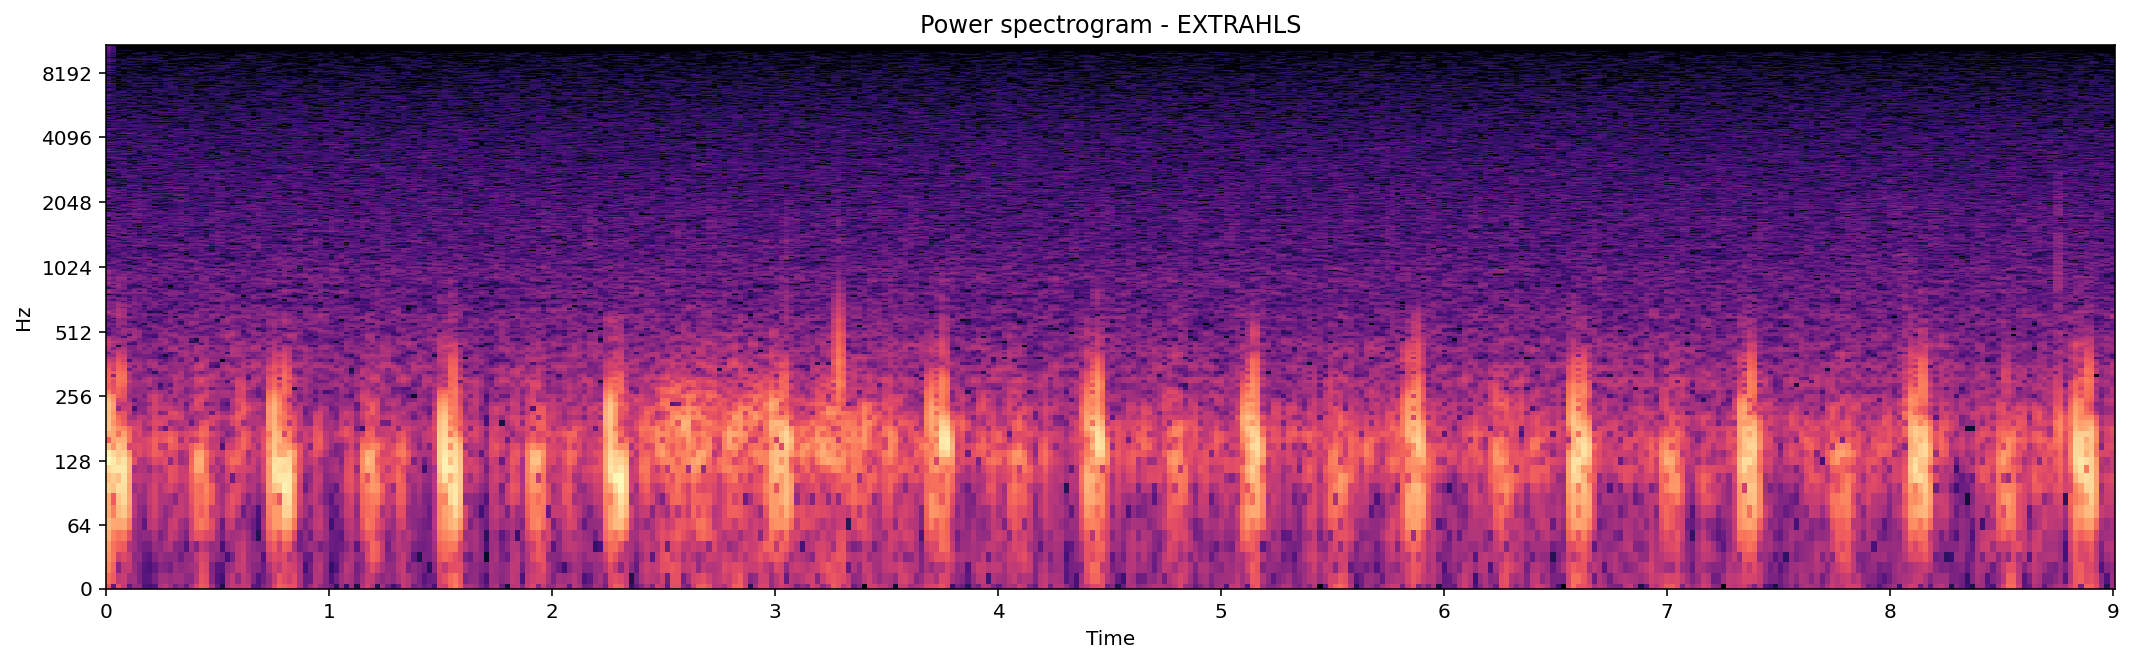

In [25]:
plot('archive/set_a/extrahls__201102241217.wav', 'spectogram', 'EXTRAHLS')

El sampling rate por defecto es: 22050
La duración del audio es: 9.0
El tamaño de y (con las amplitudes correspondientes de la onda en t) es: (198450,)
Las dimensiones del MFCC son (13, 388) lo que implica que hay 13 muestras y 388 coeficientes de MFCC


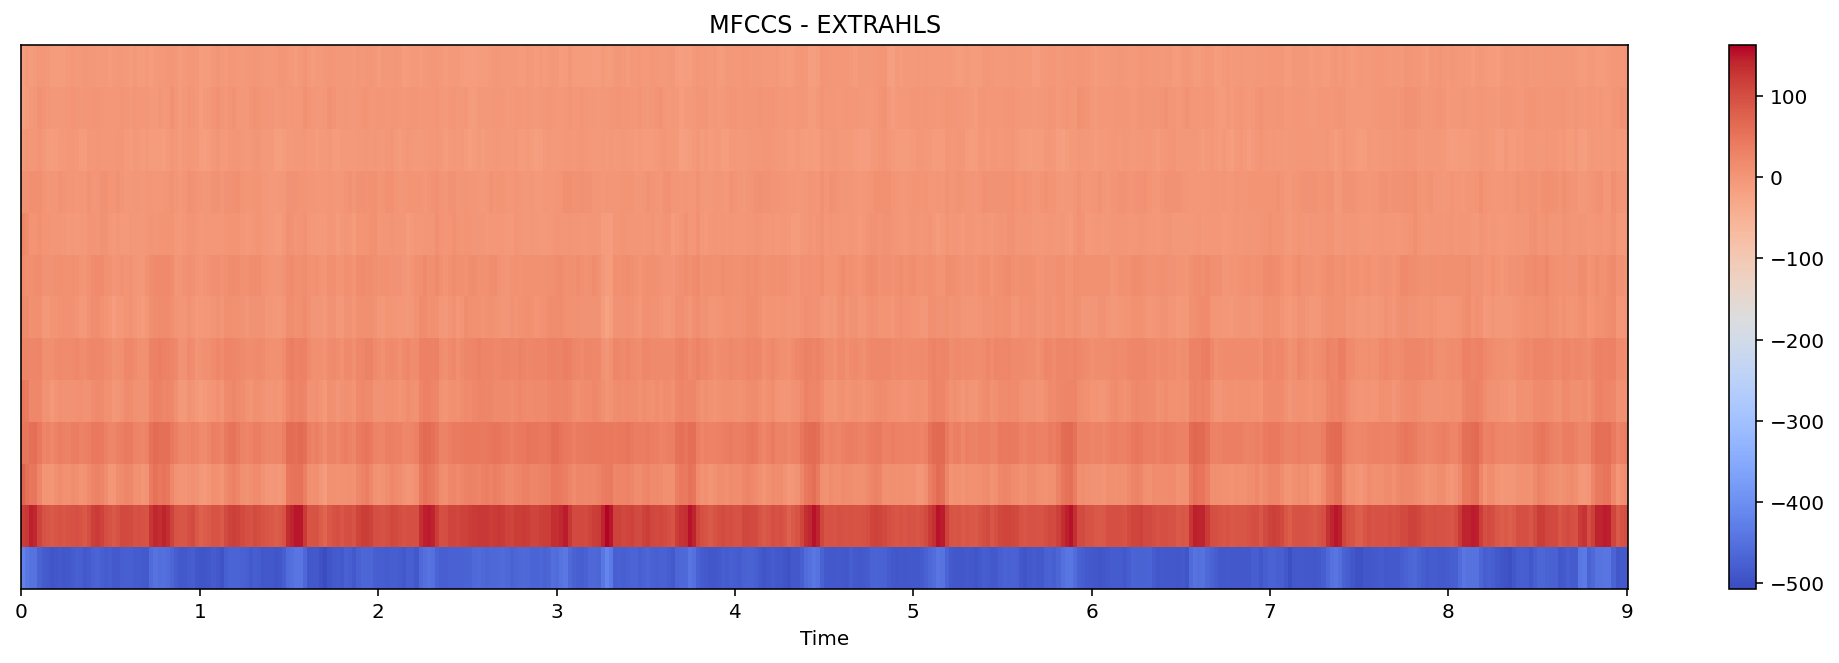

In [26]:
plot('archive/set_a/extrahls__201102241217.wav', 'MFCC', 'EXTRAHLS')

### 4. Model Generation

In [27]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os, fnmatch

In [28]:
print("Number of training examples=", train_dataset.shape[0], "  Number of classes=", len(train_dataset.label.unique()), "Labels = ", train_dataset.label.unique())

Number of training examples= 832   Number of classes= 6 Labels =  ['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


In [29]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [30]:
# simple encoding of categories, limited to 3 types


# Map label text to integer
CLASSES = ['artifact','extrahls','murmur','normal','extrastole']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}
 
{0: 'artifact', 1: 'extrahls', 2: 'murmur', 3: 'normal', 4: 'extrastole'}


In [31]:
INPUT_DIR='archive'
A_folder=INPUT_DIR+'/set_a/'
MAX_SOUND_CLIP_DURATION=12
# set-a
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [3 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [2 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]
print ("loaded dataset-a")

load file  archive/set_a/artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  archive/set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  archive/set_a/artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  archive/set_a/artifact__201105061143.wav
fixing audio lenght : artifact__201105061143.wav
load file  archive/set_a/artifact__201106141701.wav
fixing audio lenght : artifact__201106141701.wav
load file  archive/set_a/artifact__201106070537.wav
fixing audio lenght : artifact__201106070537.wav
load file  archive/set_a/artifact__201106161016.wav
fixing audio lenght : artifact__201106161016.wav
load file  archive/set_a/artifact__201106171003.wav
fixing audio lenght : artifact__201106171003.wav
load file  archive/set_a/artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  archive/set_a/artifact__201106021541.wav
fixing audio lenght : artifact__2011060

In [32]:
# load dataset-b, keep them separate for testing purpose 
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [3 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [2 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [4 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

935880_D.wav
fixing audio lenght : Bunlabelledtest__210_1308162935880_D.wav
load file  archive/set_b/Bunlabelledtest__232_1308748524018_D.wav
fixing audio lenght : Bunlabelledtest__232_1308748524018_D.wav
load file  archive/set_b/Bunlabelledtest__193_1308078104592_D.wav
load file  archive/set_b/Bunlabelledtest__202_1308145175747_B.wav
fixing audio lenght : Bunlabelledtest__202_1308145175747_B.wav
load file  archive/set_b/Bunlabelledtest__134_1306428161797_B.wav
fixing audio lenght : Bunlabelledtest__134_1306428161797_B.wav
load file  archive/set_b/Bunlabelledtest__282_1311166081161_D.wav
fixing audio lenght : Bunlabelledtest__282_1311166081161_D.wav
load file  archive/set_b/Bunlabelledtest__154_1306935608852_D.wav
fixing audio lenght : Bunlabelledtest__154_1306935608852_D.wav
load file  archive/set_b/Bunlabelledtest__235_1308749032454_D1.wav
fixing audio lenght : Bunlabelledtest__235_1308749032454_D1.wav
load file  archive/set_b/Bunlabelledtest__191_1308077299430_C.wav
load file  archi

In [33]:
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [34]:
seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [35]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (585,)
data size of the array: : 585
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  4680
0

audio data shape:  (585, 40, 1)
data size of the array: : 23400
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  93600

training data shape:  (473, 40, 1)
training label shape:  (473, 5)

validation data shape:  (53, 40, 1)
validation label shape:  (53, 5)

test data shape:  (59, 40, 1)
test label shape:  (59, 5)


In [36]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=128, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

Build LSTM RNN model ...


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported